In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torch.utils.data.dataloader as dataloader
from torchinfo import summary

# Data loading and Pre-processing

In [2]:
batch_size = 64
num_classes = 10
num_epochs = 10
num_channels = 1
learning_rate = 0.001
patch_size = 7
image_size = 28
patch_number = (image_size/patch_size) ** 2
attention_heads = 8
embedding_dim = 128
transformer_layers = 6
mlp_dim = 256
dropout = 0.1

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = torchvision.datasets.MNIST(
    root='./data',
    train=True,
    transform=transform,
    download=True
)
test_dataset = torchvision.datasets.MNIST(
    root='./data',
    train=False,
    transform=transform,
    download=True
)

In [4]:
train_data = dataloader.DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True
)
test_data = dataloader.DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=True
)

In [5]:
images, labels = next(iter(train_data))
print(images.shape, labels)
patch_embed = nn.Conv2d(num_channels, embedding_dim, patch_size, int(image_size/patch_size), 2)
print(patch_embed(images).shape)

torch.Size([64, 1, 28, 28]) tensor([6, 5, 5, 7, 8, 0, 1, 6, 5, 6, 9, 0, 9, 7, 1, 7, 1, 3, 0, 2, 1, 7, 8, 1,
        8, 9, 0, 1, 4, 8, 5, 6, 4, 7, 2, 3, 9, 8, 0, 6, 2, 6, 0, 5, 9, 8, 6, 5,
        7, 1, 8, 1, 9, 2, 2, 6, 9, 9, 3, 6, 3, 5, 3, 2])
torch.Size([64, 128, 7, 7])


# Class for Patch_Embedding

In [6]:
class PatchEmbedding(nn.Module):
    def __init__(self, in_channels=num_channels, embed_dim=embedding_dim, patch_size=patch_size):
        super(PatchEmbedding, self).__init__()
        self.patch_size = patch_size
        self.proj = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        x = self.proj(x)  # (B, embed_dim, H/patch_size, W/patch_size)
        x = x.flatten(2)  # (B, embed_dim, N)
        x = x.transpose(1, 2)  # (B, N, embed_dim)
        return x

# Class for Transformer Encoader

1. Layer Normalization
2. Multihead Attention
3. Layer Normalization
4. Residual Connections
5. Multilayer Perceptron -Activation Function


PyTorch’s `nn.MultiheadAttention` **expects input shape `(sequence_length, batch_size, embed_dim)`**, instead of `(batch_size, sequence_length, embed_dim)` which is more common in vision tasks. The reason is mostly historical and efficiency-related:

1. **Efficiency for sequence operations:**
   Multi-head attention was originally designed for NLP tasks, where sequences can be very long (like 512 tokens). Storing the sequence dimension first (`seq_len`) allows PyTorch to optimize internal operations for attention computation efficiently.

2. **Consistency with papers:**
   Many original transformer papers and implementations (like the “Attention is All You Need” paper) treat the sequence dimension as the first dimension. PyTorch followed that convention.

3. **Batch dimension last in low-level computation:**
   This layout makes it easier for the attention calculation to broadcast over batches without extra reshaping inside the function.

So, because your `PatchEmbedding` gives `(B, N, embed_dim)`, you **transpose to `(N, B, embed_dim)`**, feed it to `MultiheadAttention`, and then transpose back to `(B, N, embed_dim)` to continue using it with other modules.

It’s basically a **PyTorch requirement** due to how `nn.MultiheadAttention` was implemented, not a deep theoretical reason.

In [7]:
class TransformerEncoder(nn.Module):
    def __init__(self, embed_dim = embedding_dim, attention_heads = attention_heads, dropout = dropout, mlp_dim =mlp_dim) -> None:
        super().__init__()
        self.layer_norm_1 = nn.LayerNorm(embed_dim)
        self.multi_head_attention = nn.MultiheadAttention(embed_dim, attention_heads, dropout, bias = True)
        self.layer_norm_2 = nn.LayerNorm(embed_dim)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, mlp_dim),
            nn.ReLU(),
            nn.Linear(mlp_dim, embed_dim)
        )

    def forward(self, x):
        # x: (B, N, embed_dim) -> transpose to (N, B, embed_dim)
        x = x.transpose(0, 1)

        residual_1 = x
        x = self.layer_norm_1(x)
        x = self.multi_head_attention(x, x, x)[0] + residual_1

        residual_2 = x
        x = self.layer_norm_2(x)
        x = self.mlp(x) + residual_2

        # transpose back to (B, N, embed_dim)
        x = x.transpose(0, 1)
        return x

# MLP head for Classification

In [8]:
class MLPhead(nn.Module):
    def __init__(self, embed_dim = embedding_dim, mlp_dim =mlp_dim) -> None:
        super().__init__()
        self.layer_norm_1 = nn.LayerNorm(embed_dim)
        self.mlp_head = nn.Sequential(
            nn.Linear(embed_dim, mlp_dim),
            nn.Linear(mlp_dim, embed_dim)
        )
    def forward(self, x):
        x = self.layer_norm_1(x)
        x = self.mlp_head(x)
        return x

In [9]:
class VisionTransformer(nn.Module):
    def __init__(self, img_size=image_size, patch_size=patch_size, in_channels=num_channels,
                 num_classes=num_classes, embed_dim=embedding_dim, depth=transformer_layers,
                 num_heads=attention_heads, mlp_dim=mlp_dim, dropout = dropout):
        super(VisionTransformer, self).__init__()
        self.patch_embed = PatchEmbedding(in_channels, embed_dim, patch_size)
        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.randn(1, (img_size // patch_size) ** 2 + 1, embed_dim))
        self.transformer_blocks = nn.Sequential(*[TransformerEncoder(embed_dim, num_heads, dropout,mlp_dim) for _ in range(depth)])
        self.mlp_head = MLPhead()

    def forward(self, x):
        B = x.size(0)   # This is the batch size
        x = self.patch_embed(x)
        cls_tokens = self.cls_token.expand(B, -1, -1)   # -1 means we are keeping that specific dimension
        x = torch.cat((cls_tokens, x), dim=1)   # We are adding the batch size in dim=1 so previously we have (B,N,E) we will then have(B,N+1,E)
        x = x + self.pos_embed
        x = self.transformer_blocks(x)
        x = x[:, 0]
        x = self.mlp_head(x)
        return x

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = VisionTransformer(
    img_size=image_size,
    patch_size=patch_size,
    in_channels=num_channels,
    num_classes=num_classes,
    embed_dim=embedding_dim,
    depth=transformer_layers,
    num_heads=attention_heads,
    mlp_dim=mlp_dim,
    dropout=dropout
).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()
summary(model)

Layer (type:depth-idx)                                       Param #
VisionTransformer                                            2,304
├─PatchEmbedding: 1-1                                        --
│    └─Conv2d: 2-1                                           6,400
├─Sequential: 1-2                                            --
│    └─TransformerEncoder: 2-2                               --
│    │    └─LayerNorm: 3-1                                   256
│    │    └─MultiheadAttention: 3-2                          66,048
│    │    └─LayerNorm: 3-3                                   256
│    │    └─Sequential: 3-4                                  65,920
│    └─TransformerEncoder: 2-3                               --
│    │    └─LayerNorm: 3-5                                   256
│    │    └─MultiheadAttention: 3-6                          66,048
│    │    └─LayerNorm: 3-7                                   256
│    │    └─Sequential: 3-8                                  65,920
│    └─Tr

# Training Loop

In [11]:
for batch_idx, (data, targets) in enumerate(train_data):
    print(data.shape)
    print(targets.shape)
    print(batch_idx)
    proj = nn.Conv2d(num_channels, embedding_dim, kernel_size=patch_size, stride=patch_size)
    cls_token = nn.Parameter(torch.randn(1, 1, embedding_dim))
    pos_embed = nn.Parameter(torch.randn(1, (image_size // patch_size) ** 2 + 1, embedding_dim))
    B = data.size(0)
    x = proj(data)  # (B, embed_dim, H/patch_size, W/patch_size)
    x = x.flatten(2)  # (B, embed_dim, N)
    x = x.transpose(1, 2)  # (B, N, embed_dim)
    print(x.shape)
    cls_tokens = cls_token.expand(B, -1, -1)   # -1 means we are keeping that specific dimension
    x = torch.cat((cls_tokens, x), dim=1)   # We are adding the batch size in dim=1 so previously we have (B,N,E) we will then have(B,N+1,E)
    x = x + pos_embed
    print(x.shape)
    layer_norm_1 = nn.LayerNorm(embedding_dim)
    multi_head_attention = nn.MultiheadAttention(embedding_dim, attention_heads, dropout, bias = True)
    layer_norm_2 = nn.LayerNorm(embedding_dim)
    mlp = nn.Sequential(
        nn.Linear(embedding_dim, mlp_dim),
        nn.ReLU(),
        nn.Linear(mlp_dim, embedding_dim)
    )
    # x: (B, N, embed_dim) -> transpose to (N, B, embed_dim)
    x = x.transpose(0, 1)
    residual_1 = x
    x = layer_norm_1(x)
    x = multi_head_attention(x, x, x)[0] + residual_1
    residual_2 = x
    x = layer_norm_2(x)
    x = mlp(x) + residual_2
    # transpose back to (B, N, embed_dim)
    x = x.transpose(0, 1)
    print(x.shape)
    x = x[:, 0]
    print(x.shape)
    layer_norm_3 = nn.LayerNorm(embedding_dim)
    mlp_head = nn.Sequential(
    nn.Linear(embedding_dim, mlp_dim),
    nn.Linear(mlp_dim, embedding_dim)
    )
    # x = x[:,0]    # Here is the error that I made in the MLPhead class which I trouble shooted using this code block
    x = layer_norm_3(x)
    x = mlp_head(x)
    print(x.shape)
    print(x.argmax(dim=1))
    break

torch.Size([64, 1, 28, 28])
torch.Size([64])
0
torch.Size([64, 16, 128])
torch.Size([64, 17, 128])
torch.Size([64, 17, 128])
torch.Size([64, 128])
torch.Size([64, 128])
tensor([47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47,
        47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47,
        47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47,
        47, 47, 47, 47, 47, 47, 47, 47, 47, 47])


In [12]:
print(f'Starting training on device: {device}')
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    test_accuracy = 0
    total = 0
    correct = 0
    for batch_idx, (data, targets) in enumerate(train_data):
        data = data.to(device)
        targets = targets.to(device)
        optimizer.zero_grad()
        outputs = model(data)

        predicted = outputs.argmax(dim=1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_data)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')
    train_accuracy = 100 * correct / total

    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, targets in test_data:
            data = data.to(device)
            targets = targets.to(device)
            outputs = model(data)
            predicted = outputs.argmax(dim=1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()

    test_accuracy = 100 * correct / total
    print(f'Accuracy of the model on the train images: {train_accuracy:.2f}% and test images: {test_accuracy:.2f}%')

Starting training on device: cuda
Epoch [1/10], Loss: 0.3840
Accuracy of the model on the train images: 87.67% and test images: 95.51%
Epoch [2/10], Loss: 0.1447
Accuracy of the model on the train images: 95.57% and test images: 96.16%
Epoch [3/10], Loss: 0.1185
Accuracy of the model on the train images: 96.35% and test images: 96.25%
Epoch [4/10], Loss: 0.1049
Accuracy of the model on the train images: 96.80% and test images: 97.26%
Epoch [5/10], Loss: 0.0946
Accuracy of the model on the train images: 97.15% and test images: 97.75%
Epoch [6/10], Loss: 0.0853
Accuracy of the model on the train images: 97.33% and test images: 97.42%
Epoch [7/10], Loss: 0.0791
Accuracy of the model on the train images: 97.55% and test images: 97.68%
Epoch [8/10], Loss: 0.0735
Accuracy of the model on the train images: 97.71% and test images: 97.85%
Epoch [9/10], Loss: 0.0717
Accuracy of the model on the train images: 97.69% and test images: 97.70%
Epoch [10/10], Loss: 0.0647
Accuracy of the model on the 

In [14]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_data:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

test_acc = 100.0 * correct / total
print(f"\n==> Val Accuracy: {test_acc:.2f}%")



==> Val Accuracy: 98.20%


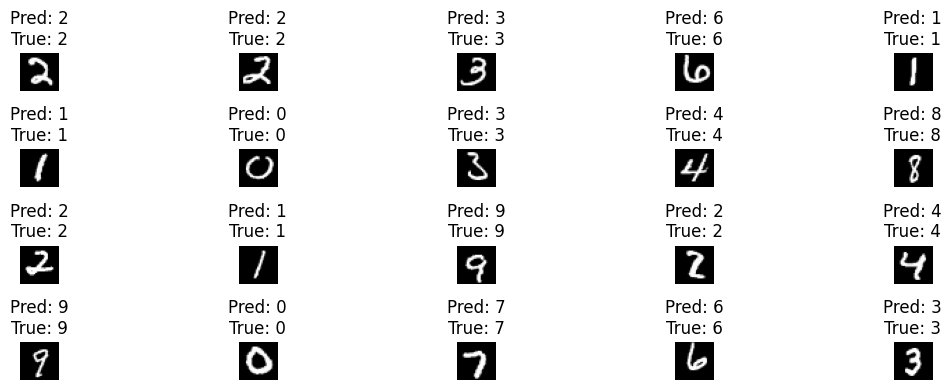

In [17]:
model.eval()
images, labels = next(iter(test_data))
images, labels = images.to(device), labels.to(device)

with torch.no_grad():
    outputs = model(images)
    preds = outputs.argmax(dim=1)

# Move tensors to CPU before converting to numpy / plotting
images_cpu = images.cpu()
preds_cpu = preds.cpu()
labels_cpu = labels.cpu()

plt.figure(figsize=(12, 4))
n = min(20, images_cpu.size(0))
for i in range(n):
    plt.subplot(4, 5, i+1)
    plt.imshow(images_cpu[i].squeeze(), cmap='gray')
    plt.title(f"Pred: {int(preds_cpu[i].item())}\nTrue: {int(labels_cpu[i].item())}")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [18]:

# Save the trained model
model_path = './trained_vit_mnist.pth'
torch.save(model.state_dict(), model_path)
print(f'Model saved to {model_path}')

# Optional: Save complete model architecture and weights
complete_model_path = './trained_vit_mnist_complete.pth'
torch.save({
    'model_state_dict': model.state_dict(),
    'model_architecture': {
        'img_size': image_size,
        'patch_size': patch_size,
        'in_channels': num_channels,
        'num_classes': num_classes,
        'embed_dim': embedding_dim,
        'depth': transformer_layers,
        'num_heads': attention_heads,
        'mlp_dim': mlp_dim,
        'dropout': dropout
    }
}, complete_model_path)
print(f'Complete model saved to {complete_model_path}')


Model saved to ./trained_vit_mnist.pth
Complete model saved to ./trained_vit_mnist_complete.pth
